This notebook contains the code for an example of running our algorithm on Dixit perturb-seq real dataset. We also run UT-IGSP algorithm and generate the ROC figures for both methods via running the algorithms with different hyperparameters. 

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import os

Import the ground truth model and auxiliary functions for Dixit dataset.

In [2]:
from realdata.dixit.dixit_meta import EFFECTIVE_NODES, DIXIT_FIGURES_FOLDER
from realdata.dixit.dixit_meta import dixit_get_samples, nnodes, true_B_dixit_paper


Import our algorithm and the necessary components from causaldag package to run UT-IGSP

In [3]:
from functions import run_ours_real
from causaldag import unknown_target_igsp
from causaldag import MemoizedCI_Tester, MemoizedInvarianceTester, gauss_invariance_test, gauss_invariance_suffstat
from causaldag import partial_correlation_test, partial_correlation_suffstat
from causaldag import hsic_test, hsic_invariance_test, kci_test, kci_invariance_test

In [4]:
ALGS2COLORS = dict(zip(['ours','utigsp_gauss', 'utigsp_star_gauss', 'utigsp_hsic','utigsp_star_hsic'],\
                       mcolors.BASE_COLORS))
ALGS2MARKERS = {'ours':'o','utigsp_gauss': 'P', 'utigsp_star_gauss': '*', 'utigsp_hsic': 'X', 'utigsp_star_hsic': 'x'}

In [5]:
# conventionally accepted ground truth DAG and skeleton
B = true_B_dixit_paper.copy()
np.fill_diagonal(B, 0)
correct_skeleton = B + B.T
correct_skeleton[np.where(correct_skeleton)] = 1
n_possible_skeleton = int(nnodes*(nnodes-1)/2)
n_true_skeleton = int(np.sum(correct_skeleton)/2)

Create the functions to run UT-IGSP algorithm (ours is already imported) and the function to interpret the results.

In [6]:
def run_utigsp_real(setting_list,obs_samples,iv_samples_list,ci_test='gauss',alpha=1e-3,alpha_i=1e-5,no_targets=True):
    if ci_test == 'gauss':
        obs_suffstat = partial_correlation_suffstat(obs_samples)
        invariance_suffstat = gauss_invariance_suffstat(obs_samples, iv_samples_list)
        ci_tester = MemoizedCI_Tester(partial_correlation_test, obs_suffstat, alpha=alpha)
        invariance_tester = MemoizedInvarianceTester(gauss_invariance_test, invariance_suffstat, alpha=alpha_i)
    elif ci_test == 'hsic':
        hsic_invariance_suffstat = {iv: samples for iv, samples in enumerate(iv_samples_list)}
        hsic_invariance_suffstat['obs_samples'] = obs_samples
        ci_tester = MemoizedCI_Tester(hsic_test, obs_samples, alpha=alpha)
        invariance_tester = MemoizedInvarianceTester(hsic_invariance_test,hsic_invariance_suffstat,alpha=alpha_i)
    elif ci_test == 'kci':
        kci_invariance_suffstat = {iv: samples for iv, samples in enumerate(iv_samples_list)}
        kci_invariance_suffstat['obs_samples'] = obs_samples
        ci_tester = MemoizedCI_Tester(kci_test, obs_samples, alpha=alpha)
        invariance_tester = MemoizedInvarianceTester(kci_invariance_test,kci_invariance_suffstat,alpha=alpha_i)        

    t_start = time.time()
    est_dag, learned_interventions = unknown_target_igsp(
        setting_list,
        set(range(nnodes)),
        ci_tester,
        invariance_tester,
        no_targets = no_targets,
        nruns=10)
    
    t_past = time.time() - t_start
    est_dag = est_dag.to_amat()[0]
    est_skeleton = est_dag+est_dag.T
    est_skeleton[np.where(est_skeleton)] = 1
    
    return est_dag, est_skeleton, learned_interventions, t_past

def read_results(file, B, skeleton, nodes='all', method='utigsp',delete_bi_directions=False):
    tp = []
    fp = []
    tp_skeleton = []
    fp_skeleton = []
    for vals in file.keys():
        if method == 'utigsp':
            estimated_dag = file[vals]['estimated_dag']
        else:
            estimated_dag = file[vals]['estimated_cpdag']
            if delete_bi_directions == True:
                estimated_dag[np.where(estimated_dag*estimated_dag.T)] = 0
            
        estimated_skeleton = file[vals]['estimated_skeleton']
        if nodes == 'all':
            tp.append(int(np.sum(estimated_dag*B)))
            fp.append(int(np.sum(estimated_dag)-tp[-1]))
            tp_skeleton.append(int(np.sum(estimated_skeleton*skeleton)/2))
            fp_skeleton.append(int(np.sum(estimated_skeleton)/2 - tp_skeleton[-1]))    
        else:
            tp.append(int(np.sum(estimated_dag[:,EFFECTIVE_NODES]*B[:,EFFECTIVE_NODES])))
            fp.append(int(np.sum(estimated_dag[:,EFFECTIVE_NODES])-tp[-1]))
            tp_skeleton.append(int(np.sum(estimated_skeleton[:,EFFECTIVE_NODES]*skeleton[:,EFFECTIVE_NODES]))-\
                               int(np.sum(estimated_skeleton[EFFECTIVE_NODES][:,EFFECTIVE_NODES]*skeleton[EFFECTIVE_NODES][:,EFFECTIVE_NODES])))
            fp_skeleton.append(int(np.sum(estimated_skeleton[:,EFFECTIVE_NODES]) -\
                                   np.sum(estimated_skeleton[EFFECTIVE_NODES][:,EFFECTIVE_NODES]) - tp_skeleton[-1]))                
    
    return tp, fp, tp_skeleton, fp_skeleton

Load the data, build the sufficient stats and the format to feed to the algorithms.

In [7]:
I_nodes = EFFECTIVE_NODES
n_knock = len(I_nodes)
obs_samples, setting_list = dixit_get_samples()
# get only the interventional data for 8 targets
setting_list = [setting for setting in setting_list if list(setting['known_interventions'])[0] in I_nodes]
iv_samples_list = [setting['samples'] for setting in setting_list]
# build the sufficient stats
S_obs = (obs_samples.T@obs_samples)/obs_samples.shape[0]
S_int = {}
for idx_setting in range(len(setting_list)):
    samples_current = setting_list[idx_setting]['samples']
    S_current = (samples_current.T @ samples_current)/samples_current.shape[0]
    S_int['setting_%d'%idx_setting] = S_current

We note that our algorithm uses ADMM-based $\Delta_\Theta$ estimation at several stages, which calls for different $\lambda$ sparsity regularization parameters. Their choice can be dependent on the properties of the data.

We use $\lambda_1$ in paper, *lambda_l1* below, for estimating $\Delta_\Theta$ over a number of nodes, e.g., initial estimation over $p$ nodes and running the algorithm for each group. $\lambda_2$ in paper, *pair_l1* below, is used while building root ancestor sets, $J_k^k$'s in paper. More importantly for causal discovery, $\lambda_3$ in paper, *parent_l1* below, is used for parent discovery step. First two parameters do not affect the results much, the last one acts as a thresholder. We vary these parameters below to generate multiple instances and ROC curve.

In [8]:
'Our algorithm'
# for Delta_Theta estimations
lambda_l1 = 0.1
# for J0 threshold
single_threshold = 0.05
# for building J0 descendants
pair_l1 = 0.05
# remove the small values after J0 descendants built
pair_threshold = 0.005
# always taken one. ADMM parameter
rho = 1.0

# this is more important one. Penalty parameter for parent selection
parent_l1_list = [0.005,0.01,0.02,0.03,0.04,0.05,0.06,0.08,0.09,0.10]

In [9]:
results = {}
for parent_l1 in parent_l1_list:
    parameters = (lambda_l1, single_threshold, pair_l1, pair_threshold, parent_l1, rho) 
    results[parameters] = {}
    est_cpdag, est_skeleton, I_hat_all, I_hat_parents_all, Ij_hat_parents_all, N_lists_all, A_groups_all, time_all = \
        run_ours_real(S_obs,S_int,lambda_l1,single_threshold,pair_l1,pair_threshold,parent_l1,rho)  
        
    results[parameters]['estimated_cpdag'] = est_cpdag
    results[parameters]['estimated_skeleton'] = est_skeleton
    results[parameters]['I_hat'] = I_hat_all
    results[parameters]['I_hat_parents'] = I_hat_parents_all
    results[parameters]['Ij_hat_parents'] = Ij_hat_parents_all
    results[parameters]['N_lists'] = N_lists_all
    results[parameters]['A_groups'] = A_groups_all
    results[parameters]['time'] = time_all

Al_sizes: [8, 3]
Al_sizes: [4, 1, 1]
Al_sizes: [2, 2, 1]
Al_sizes: [1, 1, 1]
Al_sizes: [2, 1, 3]
Al_sizes: [4, 1]
Al_sizes: [4]
Al_sizes: [6]
Al_sizes: [6, 3]
Al_sizes: [2]
Al_sizes: [5, 1]
Al_sizes: [2]
Al_sizes: [7]
Al_sizes: [6]
Al_sizes: [7]
Al_sizes: [4]
Al_sizes: [5]
Al_sizes: [6, 2]
Al_sizes: [5]
Al_sizes: [5]
Al_sizes: [3]
Al_sizes: [6]
Al_sizes: [6]
Al_sizes: [8, 3]
Al_sizes: [4, 1, 1]
Al_sizes: [2, 2, 1]
Al_sizes: [1, 1, 1]
Al_sizes: [2, 1, 3]
Al_sizes: [4, 1]
Al_sizes: [4]
Al_sizes: [6]
Al_sizes: [6, 3]
Al_sizes: [2]
Al_sizes: [5, 1]
Al_sizes: [2]
Al_sizes: [7]
Al_sizes: [6]
Al_sizes: [7]
Al_sizes: [4]
Al_sizes: [5]
Al_sizes: [6, 2]
Al_sizes: [5]
Al_sizes: [5]
Al_sizes: [3]
Al_sizes: [6]
Al_sizes: [6]
Al_sizes: [8, 3]
Al_sizes: [4, 1, 1]
Al_sizes: [2, 2, 1]
Al_sizes: [1, 1, 1]
Al_sizes: [2, 1, 3]
Al_sizes: [4, 1]
Al_sizes: [4]
Al_sizes: [6]
Al_sizes: [6, 3]
Al_sizes: [2]
Al_sizes: [5, 1]
Al_sizes: [2]
Al_sizes: [7]
Al_sizes: [6]
Al_sizes: [7]
Al_sizes: [4]
Al_sizes: [5]
Al_s

UT-IGSP algorithm is run with and without known targets for different $\alpha$ cut-off values for CI tests.

In [10]:
'UTIGSP Gauss without targets'
alpha_i = 1e-5
alpha_list = [1e-3, 2e-3, 5e-3, 1e-2, 2e-2]
utigsp_star_gauss = {}

for alpha in alpha_list:
    utigsp_star_gauss['alpha_%.3f'%alpha] = {}
    est_dag, est_skeleton, learned_interventions, t_past = \
        run_utigsp_real(setting_list,obs_samples,iv_samples_list,ci_test='gauss',alpha=alpha,alpha_i=alpha_i,no_targets=True)

    utigsp_star_gauss['alpha_%.3f'%alpha]['alpha_i'] = alpha_i
    utigsp_star_gauss['alpha_%.3f'%alpha]['estimated_dag'] = est_dag
    utigsp_star_gauss['alpha_%.3f'%alpha]['estimated_skeleton'] = est_skeleton
    utigsp_star_gauss['alpha_%.3f'%alpha]['estimated_interventions'] = learned_interventions
    utigsp_star_gauss['alpha_%.3f'%alpha]['time'] = t_past   

In [11]:
'UTIGSP Gauss with targets'
alpha_i = 1e-5
alpha_list = [1e-3, 2e-3, 5e-3, 1e-2, 2e-2]
utigsp_gauss = {}

for alpha in alpha_list:
    utigsp_gauss['alpha_%.3f'%alpha] = {}
    est_dag, est_skeleton, learned_interventions, t_past = \
        run_utigsp_real(setting_list,obs_samples,iv_samples_list,ci_test='gauss',alpha=alpha,alpha_i=alpha_i,no_targets=False)

    utigsp_gauss['alpha_%.3f'%alpha]['alpha_i'] = alpha_i
    utigsp_gauss['alpha_%.3f'%alpha]['estimated_dag'] = est_dag
    utigsp_gauss['alpha_%.3f'%alpha]['estimated_skeleton'] = est_skeleton
    utigsp_gauss['alpha_%.3f'%alpha]['estimated_interventions'] = learned_interventions
    utigsp_gauss['alpha_%.3f'%alpha]['time'] = t_past    

From the estimated models, infer the true positives and false positives.

In [12]:
ours_tp, ours_fp, ours_tp_skeleton, ours_fp_skeleton = read_results(results, B, correct_skeleton,method='ours')

utigsp_gauss_tp, utigsp_gauss_fp, utigsp_gauss_tp_skeleton, utigsp_gauss_fp_skeleton = \
    read_results(utigsp_gauss, B, correct_skeleton,method='utigsp')

utigsp_star_gauss_tp, utigsp_star_gauss_fp, utigsp_star_gauss_tp_skeleton, utigsp_star_gauss_fp_skeleton = \
    read_results(utigsp_star_gauss, B, correct_skeleton,method='utigsp')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


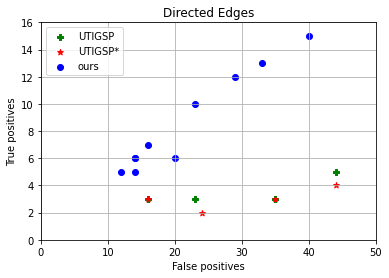

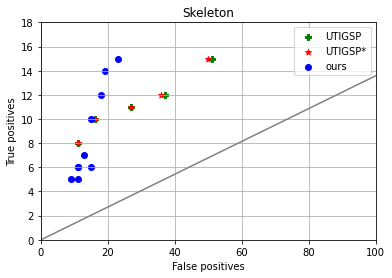

In [13]:
plt.figure('directed')
plt.scatter(utigsp_gauss_fp,utigsp_gauss_tp,label='UTIGSP',marker=ALGS2MARKERS['utigsp_gauss'],color=ALGS2COLORS['utigsp_gauss'])
plt.scatter(utigsp_star_gauss_fp,utigsp_star_gauss_tp,label='UTIGSP*',marker=ALGS2MARKERS['utigsp_star_gauss'],color=ALGS2COLORS['utigsp_star_gauss'])
plt.scatter(ours_fp,ours_tp,label='ours',marker=ALGS2MARKERS['ours'],color=ALGS2COLORS['ours'])
plt.xlim([0,50])
plt.ylim([0,16])
plt.title('Directed Edges')
plt.xlabel('False positives')
plt.ylabel('True positives')
plt.grid()
plt.legend()
plt.savefig(os.path.join(DIXIT_FIGURES_FOLDER, 'example_dixit_directed_gauss.png'))

plt.figure('skeleton')
plt.scatter(utigsp_gauss_fp_skeleton,utigsp_gauss_tp_skeleton,label='UTIGSP',marker=ALGS2MARKERS['utigsp_gauss'],color=ALGS2COLORS['utigsp_gauss'])
plt.scatter(utigsp_star_gauss_fp_skeleton,utigsp_star_gauss_tp_skeleton,label='UTIGSP*',marker=ALGS2MARKERS['utigsp_star_gauss'],color=ALGS2COLORS['utigsp_star_gauss'])
plt.scatter(ours_fp_skeleton,ours_tp_skeleton,label='ours',marker=ALGS2MARKERS['ours'],color=ALGS2COLORS['ours'])
plt.plot([0, n_possible_skeleton - n_true_skeleton], [0, n_true_skeleton], color='grey')
plt.xlim([0,100])
plt.ylim([0,18])
plt.title('Skeleton')
plt.xlabel('False positives')
plt.ylabel('True positives')
plt.grid()
plt.legend()
plt.savefig(os.path.join(DIXIT_FIGURES_FOLDER, 'example_dixit_skeleton_gauss.eps'))